In [2]:
%load_ext autoreload
%autoreload 2
import os
import sys
import numpy as np
from scipy import stats

base_dir = '/Users/simon/git/ms1fun/'
sys.path.append(base_dir + 'code')
sys.path.append(base_dir + 'dbs')

from corr_cluster import Peak,BetaLike,CorrCluster
from formula import Formula
import pylab as plt
%matplotlib inline


Grab some files

In [3]:
files = []

prefix = '/Users/simon/Dropbox/BioResearch/Meta_clustering/ms1fundata/Beer/PositiveMode/Beer3Full/csv/'
filename = 'Beer_3_Full1'
files.append((prefix,filename,False))

In [4]:
prefix = '/Users/simon/Dropbox/BioResearch/Meta_clustering/ms1fundata/urine/pos/csv/'
filename = 'Urine_37_fullscan1_POS'
files.append((prefix,filename,False))

In [5]:
prefix = '/Users/simon/Dropbox/BioResearch/Meta_clustering/ms1fundata/standards/pos/csv/'
filename = 'batch1_Std_1_1'
files.append((prefix,filename,True))

filename = 'batch1_Std_1_2'
files.append((prefix,filename,True))

filename = 'batch1_Std_2_1'
files.append((prefix,filename,True))

filename = 'batch1_Std_2_2'
files.append((prefix,filename,True))

In [6]:
import transformation
transformations = transformation.load_from_file(base_dir + 'dbs/pos_transformations_reduced.yml')
print "Loaded " + str(len(transformations)) + " transformations"

Loaded 81 transformations


Define the molecule object

In [9]:
bl = BetaLike()
clusterings = {}
for f in files:

    filename = f[1]
    prefix = f[0]
    print "Running file " + filename
    csvfile = prefix + filename + '.csv'
    matfile = prefix + filename + '.corr.mat'
    signalfile = prefix + filename + '.peakml.signal'
    # Simon is an idiot...remember to change 'correct = True' or 'correct = False' 
    # coc = CorrCluster(bl,csvfile,matfile,signal_file=signalfile,greedy_thresh=0.7,correct=True)
    coc = CorrCluster(bl,csvfile,matfile,signal_file=signalfile,greedy_thresh=0.7,correct=f[2])
    clusterings[filename] = coc

Running file Beer_3_Full1
1421.38000488
Loaded 7863 peaks
Reading shape correlations from /Users/simon/Dropbox/BioResearch/Meta_clustering/ms1fundata/Beer/PositiveMode/Beer3Full/csv/Beer_3_Full1.corr.mat
Greedy clustering done, resulting in 1116 clusters
Running file Urine_37_fullscan1_POS
Loaded 7733 peaks
Reading shape correlations from /Users/simon/Dropbox/BioResearch/Meta_clustering/ms1fundata/urine/pos/csv/Urine_37_fullscan1_POS.corr.mat
Greedy clustering done, resulting in 1237 clusters
Running file batch1_Std_1_1
1357.622802
Loaded 6150 peaks
Reading shape correlations from /Users/simon/Dropbox/BioResearch/Meta_clustering/ms1fundata/standards/pos/csv/batch1_Std_1_1.corr.mat
Greedy clustering done, resulting in 1343 clusters
Running file batch1_Std_1_2
Loaded 5624 peaks
Reading shape correlations from /Users/simon/Dropbox/BioResearch/Meta_clustering/ms1fundata/standards/pos/csv/batch1_Std_1_2.corr.mat
Greedy clustering done, resulting in 1288 clusters
Running file batch1_Std_2_1


Perform the voting...

In [12]:
from voter import Voter,PeakGroup
groups = {}
for f in files:
    v = Voter(transformations)
    filename = f[1]
    print "Performing voting on file {}".format(filename)
    file_groups = []
    for cluster in clusterings[filename].clusters:
        file_groups += v.make_groups(cluster.members)
    groups[filename] = file_groups

Performing voting on file Beer_3_Full1
Performing voting on file Urine_37_fullscan1_POS
Performing voting on file batch1_Std_1_1
Performing voting on file batch1_Std_1_2
Performing voting on file batch1_Std_2_1
Performing voting on file batch1_Std_2_2


In [39]:
from databases import Standards
st = Standards()
all_hits = {}
for f in files:
    filename = f[1]
    all_hits[filename] = st.get_group_hits(groups[filename],use_max_vote = True)

    

Output a file with the groups (and peaks that form them)

In [25]:
# Sort the groups according to votes (top ones first)
global_adduct_counts = {}
global_fragment_counts = {}
global_transformation_counts = {}
for f in files:
    filename = f[1]
    outpre = 'output/pos/' + filename

    temp_groups = sorted(groups[filename],key = lambda x:x.vote,reverse=True)
    outfile = outpre + '_by_vote.txt'
    

    with open(outfile,'w') as f:
        for i,group in enumerate(temp_groups):
            line = "vote: {}, M: {}\n".format(group.vote,group.M)
            f.write(line)
            head_line = '\tPeak m/z,Peak rt,Peak intensity,transformation (transformed mass,vote)\n'
            f.write(head_line)
            for (peak,transformation,transmass) in sorted(group.members,key = lambda x: x[1].vote,reverse=True):
                line = "\t{:.4f},{:.4f},{:.2e},{} ({:.4f},{})\n".format(peak.mass,peak.rt,peak.intensity,transformation,transmass,transformation.vote)
                f.write(line)
            f.write('\n')
            
    temp_groups = sorted(groups[filename],key = lambda x:x.M)
    outfile = outpre + '_by_M.txt'
    
    with open(outfile,'w') as f:
        for i,group in enumerate(temp_groups):
            line = "vote: {}, M: {}\n".format(group.vote,group.M)
            f.write(line)
            head_line = '\tPeak m/z,Peak rt,Peak intensity,transformation (transformed mass,vote)\n'
            f.write(head_line)
            for (peak,transformation,transmass) in sorted(group.members,key = lambda x: x[1].vote,reverse=True):
                line = "\t{:.4f},{:.4f},{:.2e},{} ({:.4f},{})\n".format(peak.mass,peak.rt,peak.intensity,transformation,transmass,transformation.vote)
                f.write(line)
            f.write('\n')

    with open(outpre + '_matched_std.txt','w') as f:
        for mol in all_hits[filename]:
            group = all_hits[filename][mol]
            line = "{} (vote={})\n".format(mol,group.vote)
            f.write(line)
            head_line = '\tPeak m/z,Peak rt,Peak intensity,transformation (transformed mass,vote)\n'
            f.write(head_line)
            for (peak,transformation,transmass) in sorted(group.members,key = lambda x: x[1].vote,reverse=True):
                line = "\t{:.4f},{:.4f},{:.2e},{} ({:.4f},{})\n".format(peak.mass,peak.rt,peak.intensity,transformation,transmass,transformation.vote)
                f.write(line)
            f.write('\n')


    include_singletons = False
    trans_counts = {}
    tot = 0
    for tr in transformations:
        trans_counts[tr] = 0
    for group in groups[filename]:
        if not include_singletons:
            if len(group.members) == 1:
                continue
        for p,t,_ in group.members:
            trans_counts[t] += 1
            tot += 1

    with open(outpre + '_tran_counts.txt','w') as f:
        for tr in sorted(transformations,key = lambda x: x.vote, reverse=True):
            line = "{},{},{:.4f}\n".format(tr,trans_counts[tr],trans_counts[tr]/(1.0*tot))
            f.write(line)

    # output the counts of particular adducts / fragments
    frag_counts = {}
    adduct_counts = {}
    adduct_tot = 0
    frag_tot = 0
    for tr in transformations:
        for f in tr.fragments:
            if not f in frag_counts:
                frag_counts[f] = 0
        for a in tr.adducts:
            if not a in adduct_counts:
                adduct_counts[a] = 0
                
    for group in groups[filename]:
        for p,t,_ in group.members:
            for f in t.fragments:
                frag_counts[f] += 1
                frag_tot += 1
            for a in t.adducts:
                adduct_counts[a] += 1
                adduct_tot += 1
                
    with open(outpre + '_adduct_counts.txt','w') as f:
        for a in adduct_counts:
            line = "{},{},{:.4f}\n".format(a,adduct_counts[a],adduct_counts[a]/(1.0*adduct_tot))
            f.write(line)
    
    with open(outpre + '_fragment_counts.txt','w') as f:
        for fr in frag_counts:
            line = "{},{},{:.4f}\n".format(fr,frag_counts[fr],frag_counts[fr]/(1.0*frag_tot))
            f.write(line)
    
    global_adduct_counts[filename] = adduct_counts
    global_fragment_counts[filename] = frag_counts
    global_transformation_counts[filename] = trans_counts

            

In [16]:
# Note this just does percentages
# Note 2 - for fragments, this is normalised according to things that have fragments
all_frags = []
for fi in global_fragment_counts:
    frags = global_fragment_counts[fi].keys()
    for fr in frags:
        if not fr in all_frags:
            all_frags.append(fr)

all_files = global_fragment_counts.keys()
totals = {}
for filename in all_files:
    tot = 0
    for fr in global_fragment_counts[filename]:
        tot += global_fragment_counts[filename][fr]
    totals[filename] = tot

frag_perc = {}
for filename in all_files:
    frag_perc[filename] = []
    for fr in all_frags:
        frag_perc[filename].append(global_fragment_counts[filename][fr]/(1.0*totals[filename]))
            
with open('output/pos/global_frags.txt','w') as f:
    st = "Fragment"
    for filename in all_files:
        st += ',{}'.format(filename)
    f.write(st+'\n')
    for fr in all_frags:
        st = fr
        for filename in all_files:
            st += ",{}".format(global_fragment_counts[filename][fr]/(1.0*totals[filename]))
        f.write(st+'\n')
        
        

        
# ADDUCTS
all_adducts = []
for fi in global_adduct_counts:
    adds = global_adduct_counts[fi].keys()
    for ad in adds:
        if not ad in all_adducts:
            all_adducts.append(ad)

all_files = global_adduct_counts.keys()
totals = {}
for filename in all_files:
    tot = 0
    for ad in global_adduct_counts[filename]:
        tot += global_adduct_counts[filename][ad]
    totals[filename] = tot
    
adduct_perc = {}
for filename in all_files:
    adduct_perc[filename] = []
    for ad in all_adducts:
        adduct_perc[filename].append(global_adduct_counts[filename][ad]/(1.0*totals[filename]))    

with open('output/pos/global_adducts.txt','w') as f:
    st = "Adduct"
    for filename in all_files:
        st += ',{}'.format(filename)
    f.write(st+'\n')
    for ad in all_adducts:
        st = ad
        for filename in all_files:
            st += ",{}".format(global_adduct_counts[filename][ad]/(1.0*totals[filename]))
        f.write(st+'\n')
        
        
        
# TRANSFORMATIONS
all_trans = []
for fi in global_transformation_counts:
    adds = global_transformation_counts[fi].keys()
    for tr in adds:
        if not tr in all_trans:
            all_trans.append(tr)

all_files = global_transformation_counts.keys()
totals = {}
for filename in all_files:
    tot = 0
    for tr in global_transformation_counts[filename]:
        tot += global_transformation_counts[filename][tr]
    totals[filename] = tot
            
        
trans_perc = {}
all_trans = global_transformation_counts[fi].keys()
all_trans = sorted(all_trans,key=lambda x: x.vote,reverse=True)
for filename in all_files:
    trans_perc[filename] = []
    for tr in all_trans:
        trans_perc[filename].append(global_transformation_counts[filename][tr]/(1.0*totals[filename]))


with open('output/pos/global_transformations.txt','w') as f:
    st = "Transformation"
    for filename in all_files:
        st += ',{}'.format(filename)
    f.write(st+'\n')
    for tr in sorted(all_trans,key = lambda x: x.vote,reverse=True):
        st = tr.name
        for filename in all_files:
            st += ",{}".format(global_transformation_counts[filename][tr]/(1.0*totals[filename]))
        f.write(st+'\n')

Output the M+H list - one peak per group

In [17]:

for f in files:
    filename = f[1]
    outpre = filename

    temp_groups = sorted(groups[filename],key = lambda x:x.vote,reverse=True)
    outfile = 'output/pos/' + outpre + '_peaklist.txt'
    print "Writing: " + outfile
    with open(outfile,'w') as of:
        for group in temp_groups:
            proto = [p for (p,t,m) in group.members if t.name == 'M+H']
            if len(proto) > 0:
                proto = proto[0]
                if proto.intensity > 1e5:
                    of.write("{},{},{}\n".format(proto.mass,proto.rt,proto.intensity))

Writing: output/pos/Beer_3_Full1_peaklist.txt
Writing: output/pos/Urine_37_fullscan1_POS_peaklist.txt
Writing: output/pos/batch1_Std_1_1_peaklist.txt
Writing: output/pos/batch1_Std_1_2_peaklist.txt
Writing: output/pos/batch1_Std_2_1_peaklist.txt
Writing: output/pos/batch1_Std_2_2_peaklist.txt


Make a clustered bar of fragments

[0, 1]
0 Urine_37_fullscan1_POS
1 Beer_3_Full1
2 batch1_Std_1_1
3 batch1_Std_1_2
4 batch1_Std_2_2
5 batch1_Std_2_1


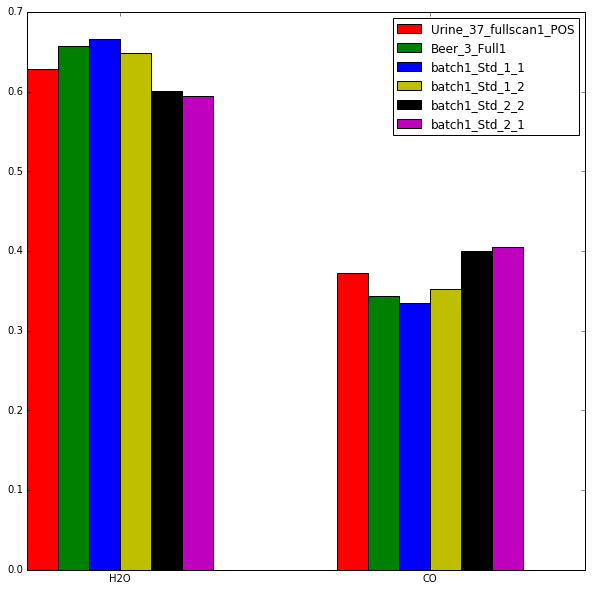

In [26]:
plt.figure(figsize=(10,10))
plt.size((10,10))
N = len(all_frags)
posn = range(N)
print posn
nfiles = len(all_files)
width = 0.1
cols = ['r','g','b','y','k','m']
rects = []
for i,filename in enumerate(all_files):
    print i,filename
    rects.append(plt.bar([p+width*i for p in posn],frag_perc[filename],width=width,color=cols[i]))
plt.legend(rects,all_files)
plt.xticks([p+width*nfiles/2 for p in posn],all_frags)
plt.savefig('output/pos/frag_bars.png',dpi=200)


Make a clustered plot of adducts

[0, 1, 2, 3, 4, 5, 6]
0 Urine_37_fullscan1_POS
1 Beer_3_Full1
2 batch1_Std_1_1
3 batch1_Std_1_2
4 batch1_Std_2_2
5 batch1_Std_2_1
[0, 1, 2, 3, 4, 5]
0 Urine_37_fullscan1_POS
1 Beer_3_Full1
2 batch1_Std_1_1
3 batch1_Std_1_2
4 batch1_Std_2_2
5 batch1_Std_2_1


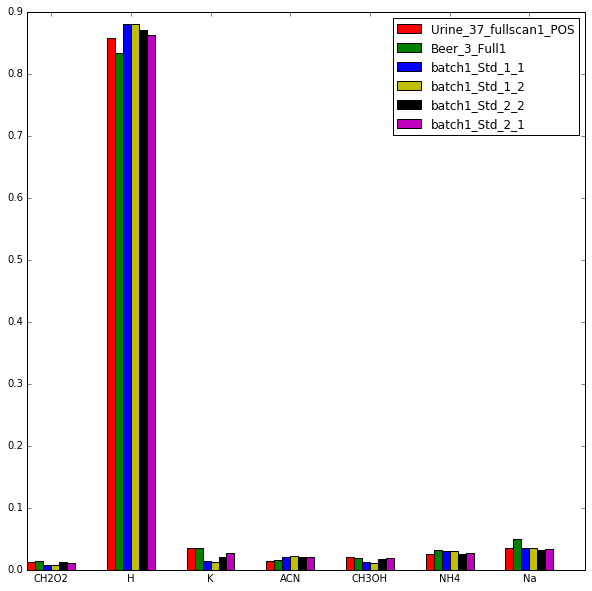

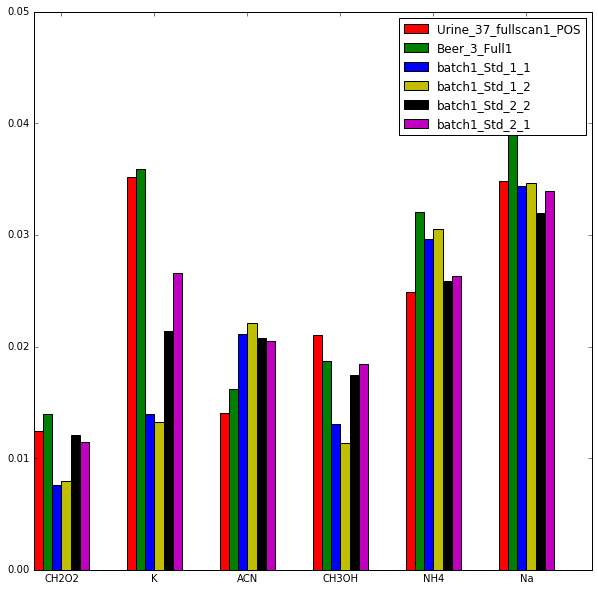

In [27]:
plt.figure(figsize=(10,10))
plt.size((10,10))
N = len(all_adducts)
posn = range(N)
print posn
nfiles = len(all_files)
width = 0.1
cols = ['r','g','b','y','k','m']
rects = []
for i,filename in enumerate(all_files):
    print i,filename
    rects.append(plt.bar([p+width*i for p in posn],adduct_perc[filename],width=width,color=cols[i]))
plt.legend(rects,all_files)
plt.xticks([p+width*nfiles/2 for p in posn],all_adducts)

import copy
# Repeat without M+H
adduct_perc2 = copy.deepcopy(adduct_perc)
all_adducts2 = copy.deepcopy(all_adducts)
mhi = all_adducts2.index("H")
del all_adducts2[mhi]
for fi in adduct_perc2:
    del adduct_perc2[fi][mhi]
    
plt.figure(figsize=(10,10))
plt.size((10,10))
N = len(all_adducts2)
posn = range(N)
print posn
nfiles = len(all_files)
width = 0.1
cols = ['r','g','b','y','k','m']
rects = []
for i,filename in enumerate(all_files):
    print i,filename
    rects.append(plt.bar([p+width*i for p in posn],adduct_perc2[filename],width=width,color=cols[i]))
plt.legend(rects,all_files)
plt.xticks([p+width*nfiles/2 for p in posn],all_adducts2)
plt.savefig('output/pos/add_bars.png',dpi=200)

Add a clustered plot of all transformations

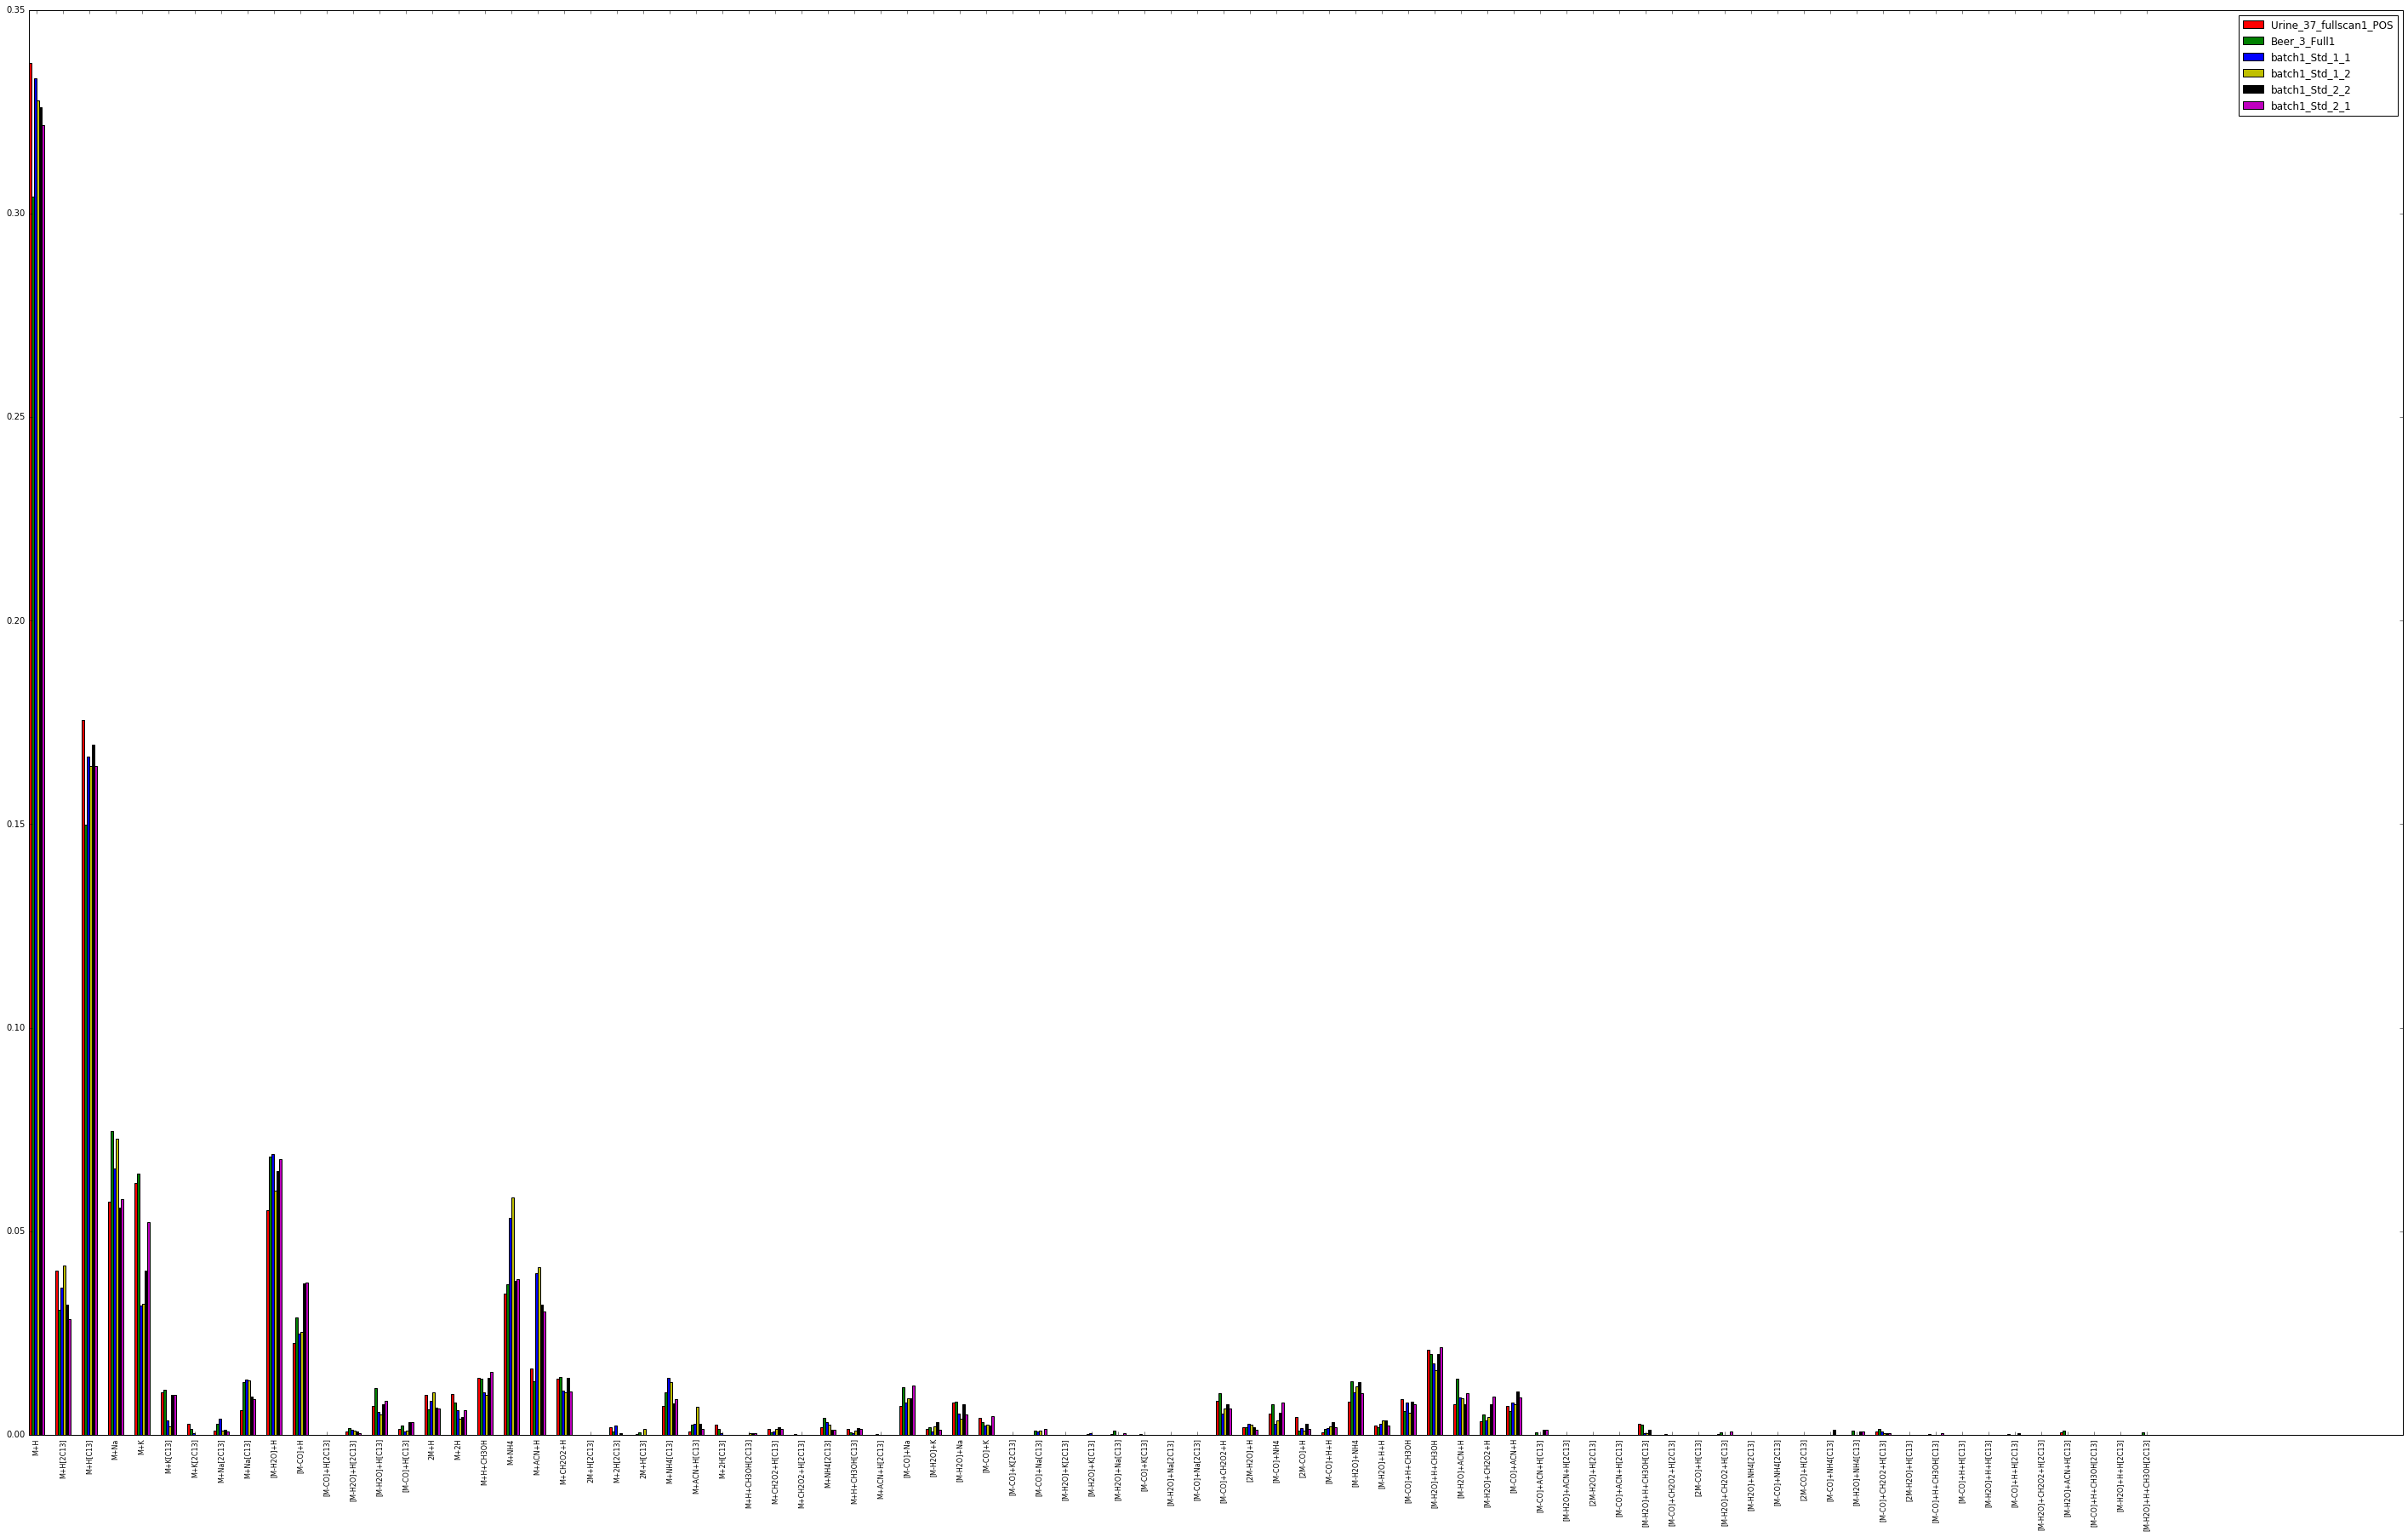

In [24]:
plt.figure(figsize=(50,30))
plt.size((10,10))
N = len(all_trans)
posn = range(N)
nfiles = len(all_files)
width = 0.1
cols = ['r','g','b','y','k','m']
rects = []
for i,filename in enumerate(all_files):
    rects.append(plt.bar([p+width*i for p in posn],trans_perc[filename],width=width,color=cols[i]))
plt.legend(rects,all_files)
plt.xticks([p+width*nfiles/2 for p in posn],all_trans,rotation=90,fontsize=8)
plt.savefig('output/pos/trans_bars.png',dpi=200)

List the transformations and their votes

In [526]:
sorted_t = sorted(transformations,key = lambda x:x.vote,reverse=True)
for tr in sorted_t:
    print tr,tr.vote

M+H 1.0
M+H[C13] 0.9
M+H[2C13] 0.9
M+K 0.6
M+Na 0.6
M+K[C13] 0.54
M+K[2C13] 0.54
M+Na[C13] 0.54
M+Na[2C13] 0.54
[M-H2O]+H 0.5
[M-CO]+H 0.5
[M-H2O]+H[C13] 0.45
[M-H2O]+H[2C13] 0.45
[M-CO]+H[C13] 0.45
[M-CO]+H[2C13] 0.45
2M+H 0.4
M+2H 0.4
M+ACN+H 0.4
M+H+CH3OH 0.4
M+NH4 0.4
2M+H[C13] 0.36
2M+H[2C13] 0.36
M+2H[C13] 0.36
M+2H[2C13] 0.36
M+ACN+H[C13] 0.36
M+ACN+H[2C13] 0.36
M+H+CH3OH[C13] 0.36
M+H+CH3OH[2C13] 0.36
M+NH4[C13] 0.36
M+NH4[2C13] 0.36
[M-H2O]+K 0.3
[M-CO]+K 0.3
[M-H2O]+Na 0.3
[M-CO]+Na 0.3
[M-H2O]+K[C13] 0.27
[M-H2O]+K[2C13] 0.27
[M-CO]+K[C13] 0.27
[M-CO]+K[2C13] 0.27
[M-H2O]+Na[C13] 0.27
[M-H2O]+Na[2C13] 0.27
[M-CO]+Na[C13] 0.27
[M-CO]+Na[2C13] 0.27
[2M-H2O]+H 0.2
[2M-CO]+H 0.2
[M-H2O]+2H 0.2
[M-CO]+2H 0.2
[M-H2O]+ACN+H 0.2
[M-CO]+ACN+H 0.2
[M-H2O]+H+CH3OH 0.2
[M-CO]+H+CH3OH 0.2
[M-H2O]+NH4 0.2
[M-CO]+NH4 0.2
[2M-H2O]+H[C13] 0.18
[2M-H2O]+H[2C13] 0.18
[2M-CO]+H[C13] 0.18
[2M-CO]+H[2C13] 0.18
[M-H2O]+2H[C13] 0.18
[M-H2O]+2H[2C13] 0.18
[M-CO]+2H[C13] 0.18
[M-CO]+2H[2C13] 0.18
[M-

Plot intensity versus group vote

In [527]:
peaki = []
gvote = []
for g in groups:
    for (p,_,_) in g.members:
        peaki.append(p.intensity)
        gvote.append(g.vote)

0.117462813251 1.43902321206e-25


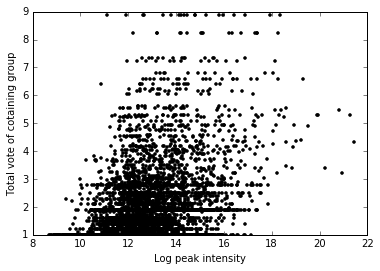

In [528]:
plt.figure()
plt.plot(np.log(peaki),gvote,'k.')
plt.xlabel('Log peak intensity')
plt.ylabel('Total vote of cotaining group')
from scipy.stats.stats import pearsonr
r,p = pearsonr(peaki,gvote)
print r,p


Look for groups that have C13 for two adducts, compute the ratios between the mono-isotope and the C13 and plot them against each other. They should lie close to the y=x line.

18


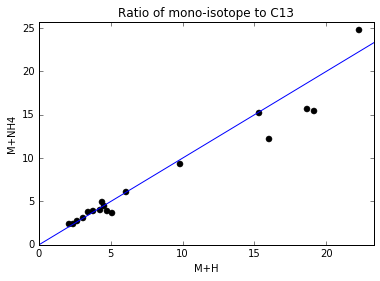

In [529]:
#Change these names to see other things
add1name = "M+H"
add2name = "M+NH4"

add1 = [t for t in transformations if t.name==add1name][0]
add1C13 = [t for t in transformations if t.name==add1name + "[C13]"][0]

add2 = [t for t in transformations if t.name==add2name][0]
add2C13 = [t for t in transformations if t.name==add2name + "[C13]"][0]




ratios = {}
for g in groups:
    # Extract the transformations
    add1I = -1
    add1C13I = -1
    add2I = -1
    add2C13I = -1
    for p,t,_ in g.members:
        if t == add1:
            add1I = p.intensity
        if t == add1C13:
            add1C13I = p.intensity
        if t == add2:
            add2I = p.intensity
        if t == add2C13:
            add2C13I = p.intensity



    if add1I > 0 and add1C13I > 0 and add2I > 0 and add2C13I > 0:
        ratios[g] = (add1I/add1C13I,add2I/add2C13I)
        if ratios[g][1] > 60:
            print g.M,ratios[g]
    


print len(ratios)

# Plot them
a = []
b = []
for r in ratios:
    a.append(ratios[r][0])
    b.append(ratios[r][1])

a = np.array(a)
b = np.array(b)

plt.figure()
plt.plot(a,b,'ko')
plt.xlim([0,a.max()+1])
plt.ylim([0,b.max()+1])
plt.plot([0,a.max()+1],[0,a.max()+1])

plt.xlabel(add1)
plt.ylabel(add2)
plt.title('Ratio of mono-isotope to C13')

Standard comparison
==
Compare the standards found in two different outputs by looking at how similar the votes are

In [40]:
file1 = files[2][1]
file2 = files[3][1]
compare1 = all_hits[file1]
compare2 = all_hits[file2]
print file1,file2

batch1_Std_1_1 batch1_Std_1_2


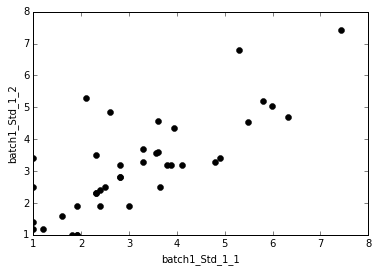

In [42]:
votes1 = []
votes2 = []
with open('{}_{}_std_comparison.txt'.format(file1,file2),'w') as f:
    for mol in compare1:
        if mol in compare2:
            group1 = compare1[mol]
            group2 = compare2[mol]
            
            votes1.append(group1.vote)
            votes2.append(group2.vote)
            
            line = "{}\n".format(mol)
            f.write(line)
            line = "{} Vote: {}, {} Vote: {}\n".format(file1,group1.vote,file2,group2.vote)
            f.write(line)
            
            line = "{}\n".format(file1)
            f.write(line)
            
            head_line = '\tPeak m/z,Peak rt,Peak intensity,transformation (transformed mass,vote,relative intensity)\n'
            f.write(head_line)
            
            # find most intense peak
            maxi = 0.0
            for (peak,_,_) in group1.members:
                if peak.intensity > maxi:
                    maxi = peak.intensity
                    
            for (peak,transformation,transmass) in sorted(group1.members,key = lambda x: x[0].intensity,reverse=True):
                line = "\t{:.4f},{:.4f},{:.2e},{} ({:.4f},{},{:.4f})\n".format(peak.mass,peak.rt,peak.intensity,transformation,transmass,transformation.vote,peak.intensity/maxi)
                f.write(line)
            f.write('\n')
            
            line = "{}\n".format(file2)
            f.write(line)
            
            head_line = '\tPeak m/z,Peak rt,Peak intensity,transformation (transformed mass,vote,relative intensity)\n'
            f.write(head_line)
            
            maxi = 0.0
            for (peak,_,_) in group2.members:
                if peak.intensity > maxi:
                    maxi = peak.intensity
            
            for (peak,transformation,transmass) in sorted(group2.members,key = lambda x: x[0].intensity,reverse=True):
                line = "\t{:.4f},{:.4f},{:.2e},{} ({:.4f},{},{:.4f})\n".format(peak.mass,peak.rt,peak.intensity,transformation,transmass,transformation.vote,peak.intensity/maxi)
                f.write(line)
            f.write('\n')
            
            f.write('\n\n\n')

            
plt.plot(votes1,votes2,'ko')
plt.xlabel(file1)
plt.ylabel(file2)

In [665]:
r,p = pearsonr(votes1,votes2)
print r,p

0.765341115719 3.56953813096e-09


Urine_37_fullscan1_POS
5455 groups, consisting of 7733 peaks
4157 singleton groups (76% of groups, 54% of peaks)
1486 peaks under threshold (1e+05), 19% of peaks
	1072 of which are singletons (72%)
414 peaks below the threshold in groups of size > 1
61 groups where the most intense peak is below the threshold (avg size = 2.08 avg vote = 1.45)
Test between intensity and vote for all peaks: corr coef = 0.302093246727, p-value = 6.68263318101e-163
Test between maximum group intensity and vote: corr coef = 0.507661325731, p-value = 0.0


Beer_3_Full1
5473 groups, consisting of 7865 peaks
4220 singleton groups (77% of groups, 54% of peaks)
1678 peaks under threshold (1e+05), 21% of peaks
	1266 of which are singletons (75%)
412 peaks below the threshold in groups of size > 1
41 groups where the most intense peak is below the threshold (avg size = 2.07 avg vote = 1.49)
Test between intensity and vote for all peaks: corr coef = 0.415267453093, p-value = 0.0
Test between maximum group intensity

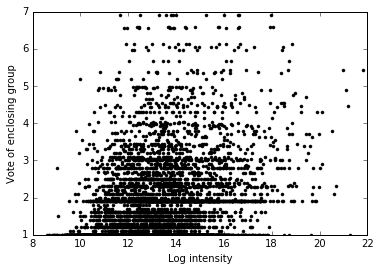

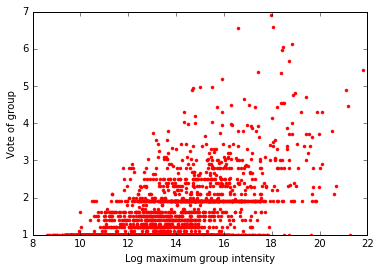

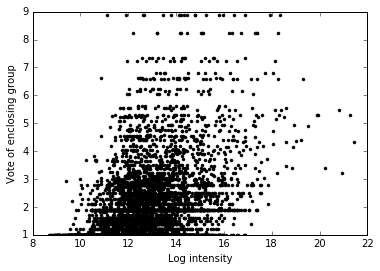

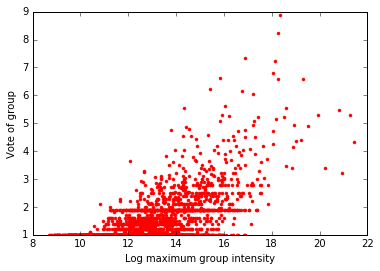

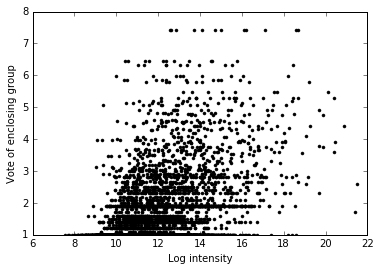

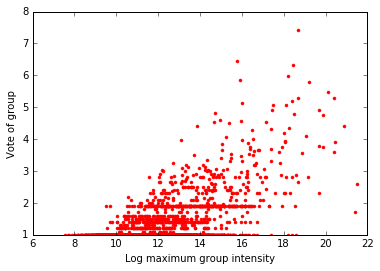

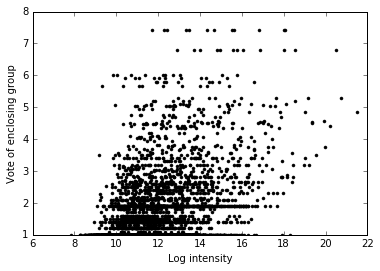

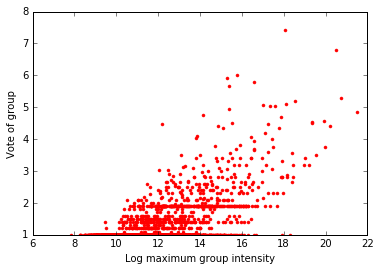

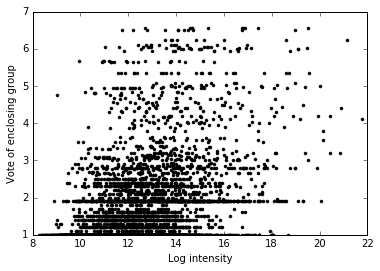

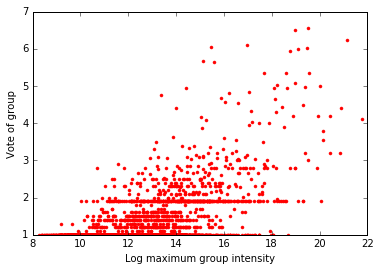

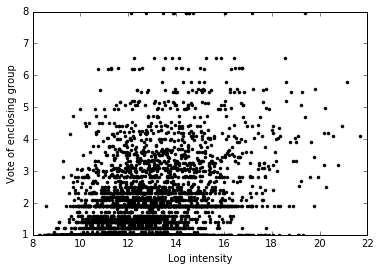

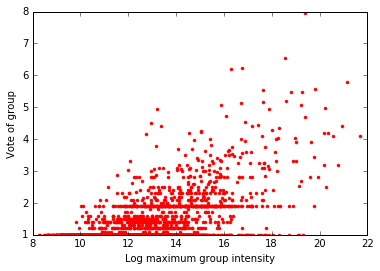

In [76]:
import helper_functions
for filename in groups:
    print filename
    helper_functions.collect_group_stats(groups[filename])
    print
    print

HMDB analysis on Urine sample
===

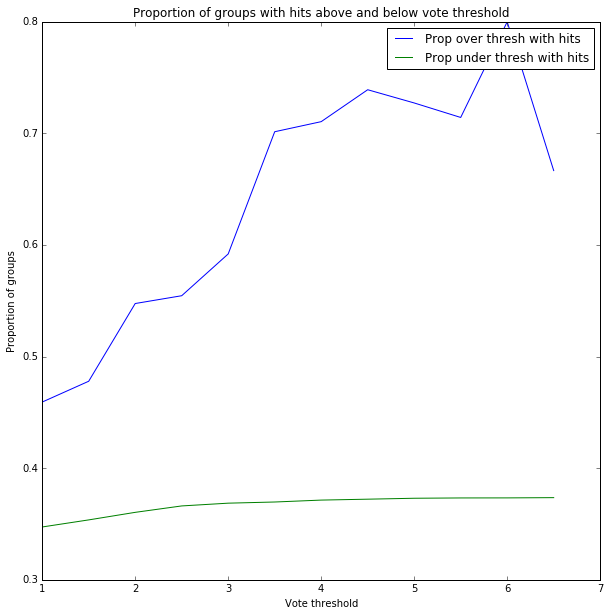

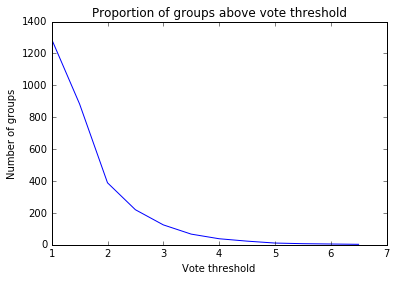

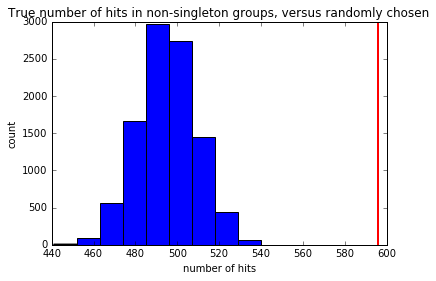

In [58]:
import helper_functions
helper_functions.hmdb_analysis(groups[files[1][1]],mode='pos',filename = files[1][1])

HMDB analysis on beer -- just to see!
==

Beer_3_Full1
Number of raw hits (i.e. comparing all peaks): 3450 (44% of peaks)
Number of group hits (i.e. hits on group Ms): 2478 (45% of groups)


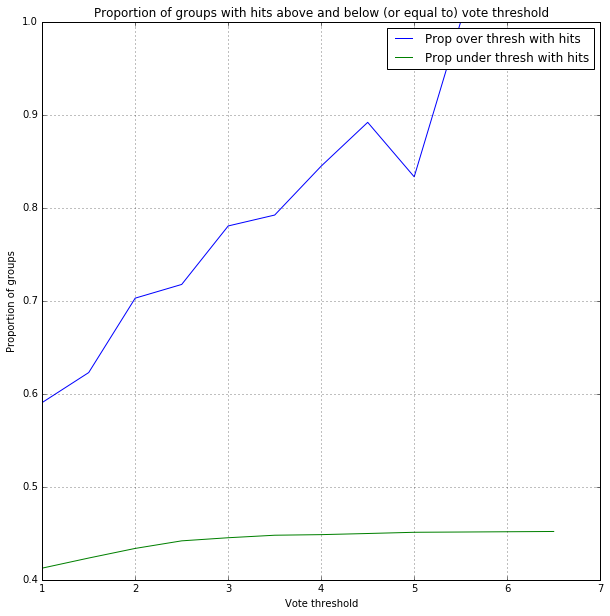

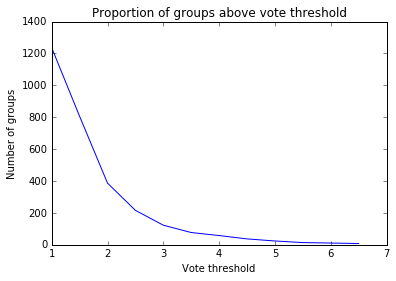

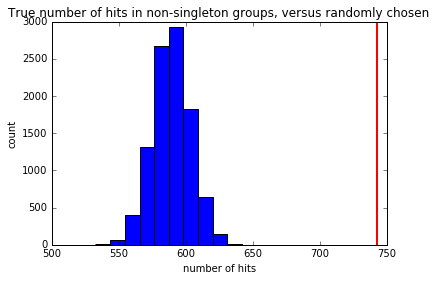

In [63]:
beerfile = files[0][1]
print beerfile
helper_functions.hmdb_analysis(groups[beerfile],mtol=10,mode='pos',filename=beerfile)

Standards analysis
==

batch1_Std_1_1
Number of raw hits (i.e. comparing all peaks): 54 (1% of peaks)
Number of group hits (i.e. hits on group Ms): 52 (1% of groups)


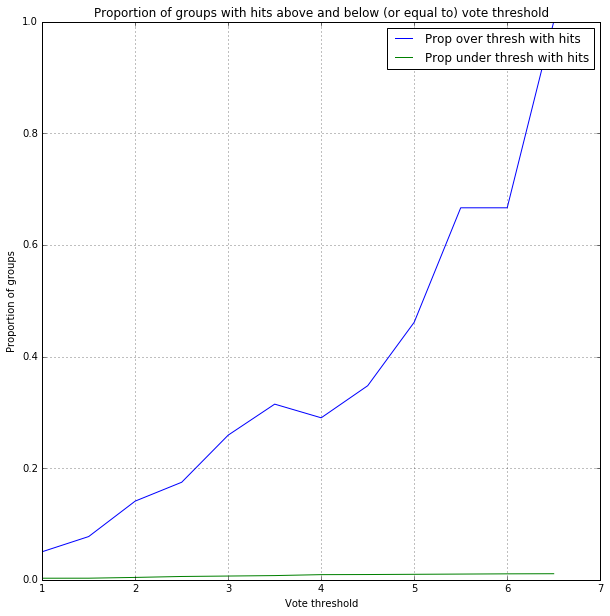

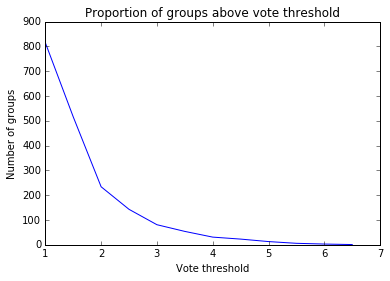

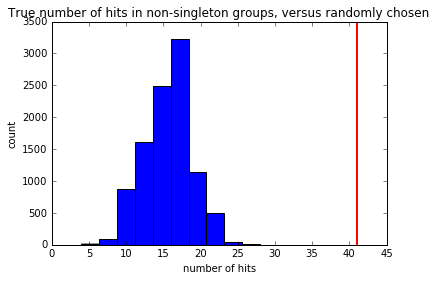

In [75]:
stdfile = files[2][1]
print stdfile
helper_functions.standard_analysis(groups[stdfile],mtol=10,rttol=10,mode='pos',filename=stdfile)